In [1]:
import os
import pickle
import time
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional
from tensorflow.keras.optimizers import SGD, Adam

from avaml.aggregatedata import ForecastDataset, LabeledData, REG_ENG, CsvMissingError
from utils.preprocess import *
from utils.feature_engineering import *
from utils.nn import *

In [2]:
print(tf.__version__)

# we need to set up gpus for tensorflow-gpu and cudnn
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)

tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

2.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Download, read in, preprocess data

## Loading data

In [4]:
model_prefix = ''
days = 7
regobs_types = list(REG_ENG.keys())
labeled_data = None
try:
    print("Reading csv")
    labeled_data = LabeledData.from_csv(days=days, regobs_types=regobs_types, with_varsom=True)
except CsvMissingError:
    print("Csv missing. Fetching online data. (This takes a long time.)")
    labeled_data = ForecastDataset(regobs_types=regobs_types).label(days=days, with_varsom=True)
    labeled_data.to_csv()

Reading csv


In [5]:
# read in data, extract data and labels
labeled_data = preprocess(labeled_data)
regions = labeled_data.data.reorder_levels([1, 0])
labels = labeled_data.label.reorder_levels([1, 0])

In [6]:
regions

,,danger_level_1,danger_level_2,danger_level_3,danger_level_4,danger_level_5,danger_level_6,emergency_warning_1,emergency_warning_2,emergency_warning_3,emergency_warning_4,...,regobs_snowprofile_t_min_4_4,regobs_snowprofile_t_min_4_5,regobs_snowprofile_t_min_4_6,regobs_snowprofile_t_min_4_7,accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6,accuracy_7
region,date,,,,,,,,,,,,,,,,,,,,,
3003,2017-12-07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,2017-12-07,3.0,2.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3009,2017-12-07,3.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3010,2017-12-07,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3011,2017-12-07,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3032,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


One of the first things we need to take care of is the precipitation column. There are some extremely high values throughout the dataset that we need to drop.

In [7]:
precip_cols = [col for col in regions.columns if 'precip' in col and 'exposed' not in col]
regions_precip = regions.loc[:, precip_cols]

There is a set of anomalously high precipitation values in this dataset that we need to be mindful of.

In [8]:
precip_outliers = np.where(regions_precip > 100)[0]

In [9]:
drop_idx = regions.index[precip_outliers]
regions = regions.drop(drop_idx)

In [10]:
regions.loc[:, precip_cols].max()

precip_0    95.6
precip_1    95.6
precip_2    95.6
precip_3    95.6
precip_4    95.6
precip_5    95.6
dtype: float64

These seem like more reasonable values. We need to do the same thing for the labels, though.

In [11]:
labels = labels.drop(drop_idx)

In [12]:
print('Shape of input data:  {}'.format(regions.shape))
print('Shape of labels    :  {}'.format(labels.shape))

Shape of input data:  (12519, 6516)
Shape of labels    :  (12519, 69)


In [13]:
# encode cause and aspect columns in labels
labels = encode_causes(labels)
labels = encode_aspects(labels)

## Feature Engineering

In a previous Notebook analysis on the importance of different features, we say that different meteorological variables from RegObs are often more important than other fields included in the data. And what's more, combining variables to create custom features is even *more* important. We can create those features again below.

**Why do we want to do feed in weather data to a neural network when other data is available?** This is a good question. Generally, we cannot send people everywhere to inspect avalanche conditions. That means that there are many places where the *only* data that we have available comes in the form of weather forecasts and observations. Thus, it is important to see if a model can predict danger level or the first avalanche problem given only weather data.

In [14]:
# drop wind speed columns
wind_dir_cols = [col for col in regions.columns if 'wind_dir' in col]
#regions.drop(wind_dir_cols, axis=1, inplace=True)

# create 72 hour sum or max of wind speed, precip, and max temp
wind_speed_cols = [col for col in regions.columns if 'wind' in col and 'speed' in col]
regions = wind_speed_max(regions, wind_speed_cols)
to_sum = ['wind_speed_max_0', 'wind_speed_max_1', 'wind_speed_max_2']
regions = sum_over_features(regions, to_sum, 'wind_speed_72hr')

to_sum = ['precip_0', 'precip_1', 'precip_2']
regions = sum_over_features(regions, to_sum, 'precip_72hr')

to_sum = ['temp_max_0', 'temp_max_1', 'temp_max_2']
regions = take_max(regions, to_sum, 'temp_max_72hr')

In [15]:
# below, think about also removing emergency warning and any columns with the word "problem" in it
dont_include_list = ['acc', 'aspect', 'dir', 'fl_start', 'regobs', 'start']
all_wx_cols = [col for col in regions.columns]

for drop_col in dont_include_list:
    all_wx_cols = [col for col in all_wx_cols if drop_col not in col]

#all_wx_cols

In [16]:
# train = regions.loc[:, all_wx_cols]
# train

In [17]:
# to include danger level
#to_include = [col for col in regions.columns if 'precip' in col or 'temp' in col or 'wind' in col or 'danger_level' in col]

# to leave danger level out
to_include = [col for col in regions.columns if 'precip' in col or 'temp' in col or 'wind' in col]

for drop_col in dont_include_list:
    to_include = [col for col in to_include if drop_col not in col]
    
train = regions.loc[:, to_include]
train

,,precip_most_exposed_0,precip_most_exposed_1,precip_most_exposed_2,precip_most_exposed_3,precip_most_exposed_4,precip_most_exposed_5,precip_0,precip_1,precip_2,precip_3,...,temp_freeze_lev_5,wind_speed_max_0,wind_speed_max_1,wind_speed_max_2,wind_speed_max_3,wind_speed_max_4,wind_speed_max_5,wind_speed_72hr,precip_72hr,temp_max_72hr
region,date,,,,,,,,,,,,,,,,,,,,,
3003,2017-12-07,8.0,4.0,4.0,8.0,10.0,5.0,1.0,0.0,0.0,0.0,...,0.000,15.5,9.0,9.0,0.0,9.0,9.0,33.5,1.0,-8.0
3007,2017-12-07,1.4,7.5,0.1,6.8,16.0,5.2,1.4,6.2,0.0,5.5,...,237.510,12.0,9.0,5.5,9.0,9.0,12.0,26.5,7.6,-5.9
3009,2017-12-07,1.8,9.0,7.6,6.4,13.0,4.4,1.5,8.0,6.2,5.4,...,267.920,15.5,5.5,9.0,9.0,9.0,9.0,30.0,15.7,-6.5
3010,2017-12-07,0.2,9.7,13.5,10.2,9.2,2.9,0.1,9.2,12.2,9.0,...,326.270,15.5,5.5,12.0,12.0,9.0,9.0,33.0,21.5,-6.2
3011,2017-12-07,0.1,10.3,15.0,13.5,9.5,3.8,0.1,9.8,14.2,11.6,...,210.565,12.0,5.5,5.5,9.0,9.0,9.0,23.0,24.1,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,0.0,10.0,15.0,20.0,2.0,0.0,0.0,5.0,10.0,15.0,...,0.000,9.0,5.5,5.5,15.5,0.0,0.0,20.0,15.0,-5.0
3032,2021-01-12,0.0,2.0,6.0,5.0,0.0,0.0,0.0,0.0,3.0,2.0,...,0.000,12.0,5.5,9.0,12.0,0.0,0.0,26.5,3.0,-9.0
3034,2021-01-12,2.0,8.0,20.0,20.0,0.0,0.0,0.0,4.0,12.0,10.0,...,0.000,9.0,5.5,9.0,12.0,5.5,5.5,23.5,16.0,-7.0


In [18]:
to_include

['precip_most_exposed_0',
 'precip_most_exposed_1',
 'precip_most_exposed_2',
 'precip_most_exposed_3',
 'precip_most_exposed_4',
 'precip_most_exposed_5',
 'precip_0',
 'precip_1',
 'precip_2',
 'precip_3',
 'precip_4',
 'precip_5',
 'wind_speed_0',
 'wind_speed_1',
 'wind_speed_2',
 'wind_speed_3',
 'wind_speed_4',
 'wind_speed_5',
 'wind_change_speed_0',
 'wind_change_speed_1',
 'wind_change_speed_2',
 'wind_change_speed_3',
 'wind_change_speed_4',
 'wind_change_speed_5',
 'temp_min_0',
 'temp_min_1',
 'temp_min_2',
 'temp_min_3',
 'temp_min_4',
 'temp_min_5',
 'temp_max_0',
 'temp_max_1',
 'temp_max_2',
 'temp_max_3',
 'temp_max_4',
 'temp_max_5',
 'temp_lev_0',
 'temp_lev_1',
 'temp_lev_2',
 'temp_lev_3',
 'temp_lev_4',
 'temp_lev_5',
 'temp_freeze_lev_0',
 'temp_freeze_lev_1',
 'temp_freeze_lev_2',
 'temp_freeze_lev_3',
 'temp_freeze_lev_4',
 'temp_freeze_lev_5',
 'wind_speed_max_0',
 'wind_speed_max_1',
 'wind_speed_max_2',
 'wind_speed_max_3',
 'wind_speed_max_4',
 'wind_speed_

In [19]:
# danger_cols = [col for col in train.columns if 'danger' in col]

# for col in danger_cols:
#     train.loc[:, col][train.loc[:, col].values == 1] = 0
#     train.loc[:, col][train.loc[:, col].values == 2] = 0
#     train.loc[:, col][train.loc[:, col].values == 3] = 0
#     train.loc[:, col][train.loc[:, col].values == 4] = 1

In [20]:
# np.unique(train[danger_cols])

### Scale data

In [21]:
scaled_X = scale_input_data(train.values)
train = pd.DataFrame(scaled_X, columns=train.columns, index=train.index)

In [22]:
# could use CLASS_danger_level or CLASS_problem_1
train_labels = labels.loc[:, ['CLASS_danger_level']]

In [23]:
class_occurrences = (train_labels.value_counts() / len(train_labels) * 100).sort_index()
round(class_occurrences, 2)

CLASS_danger_level
1                     18.82
2                     52.81
3                     26.48
4                      1.89
dtype: float64

So we see that there is a heavy imbalance in the class weights that we are trying to predict. This is not ideal for our case, because more than anything we need to reliably be able to predict danger levels 3 and 4. Scikit-learn makes this easy to do for imbalanced classification tasks.

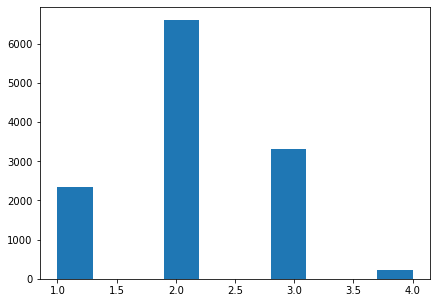

In [24]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(train_labels, align='mid', )#rwidth=0.85)
plt.show()

### Outlier Detection

Since the classes are so imbalanced, we could treat this like an outlier detection problem and only try to detect avalanche danger level 4's.

In [25]:
train_labels[train_labels.values == 1] = 0
train_labels[train_labels.values == 2] = 0
train_labels[train_labels.values == 3] = 0
train_labels[train_labels.values == 4] = 1

print(np.unique(train_labels.values))

[0 1]


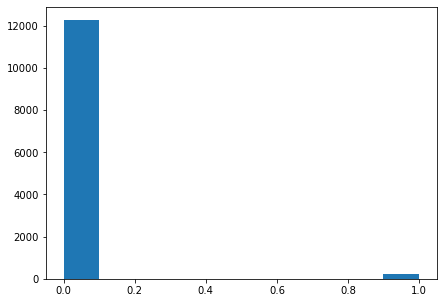

In [26]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(train_labels.values)
plt.show()

In [27]:
class_occurrences = (train_labels.value_counts() / len(train_labels) * 100).sort_index()
round(class_occurrences, 2)

CLASS_danger_level
0                     98.11
1                      1.89
dtype: float64

We can set some class weights below so that the model we train prioritizes getting danger level 4's correct. Note: this can act as another form of regularization for the model.

The weights are set to be about equal to what you would get with the [`compute_class_weight()`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) method in Scikit-Learn.

In [28]:
weights = {
    0: 0.5,
    1: 23
}

weights

{0: 0.5, 1: 23}

In [29]:
def plot_wx_dl(X, y, idx):
    """
    Plot extreme danger level against temperature, wind speed, and
    precipitation levels from the past 72 hours.
    """
    df = X.loc[idx, :]
    dl = y.loc[idx, :].values
    
    temp = df['temp_max_72hr'].values
    wind = df['wind_speed_72hr'].values
    precip = df['precip_72hr'].values
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(dl, color='k', linestyle='--', label='danger level')
    ax.plot(wind, color='lightgrey', label='wind_speed_72hr')
    ax.plot(precip, color='lightblue', label='precip_72hr')
    ax.plot(temp, color='orange', label='temp_max_72hr')

    ax.set_xlabel('Time -->')
    ax.set_ylabel('Normalized value -->')
    title = 'Temperature max, wind speed max, and precipitation sum versus danger level for region {}'.format(idx)
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1, 1))
    plt.show()

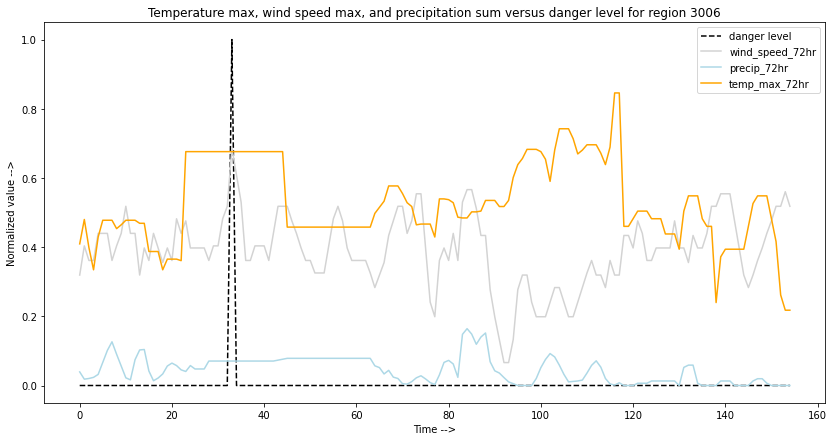

In [30]:
# northern region example
plot_wx_dl(train, train_labels, 3006)

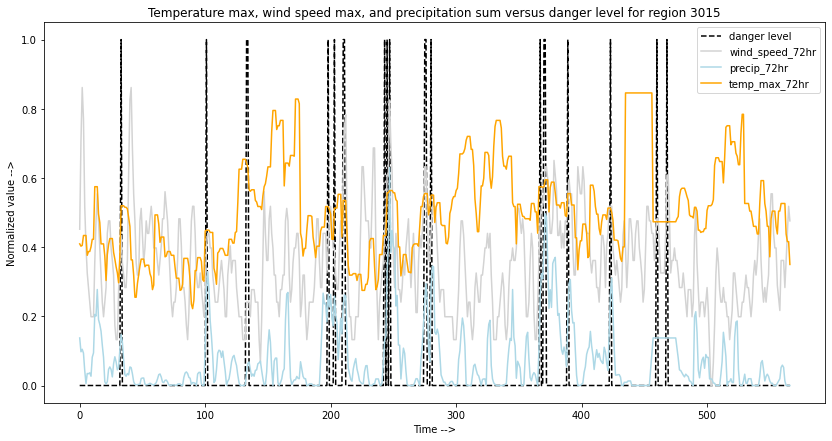

In [31]:
# central region example
plot_wx_dl(train, train_labels, 3015)

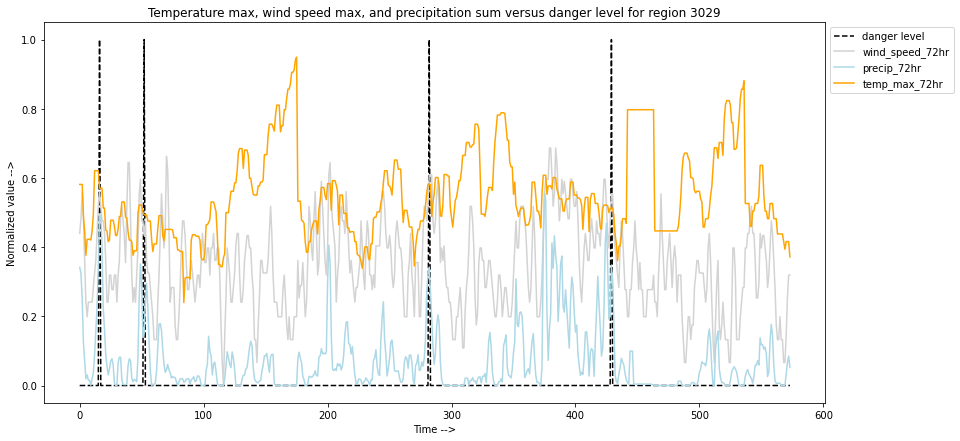

In [32]:
# southern region example
plot_wx_dl(train, train_labels, 3029)

In [33]:
dl0_labels = np.where(train_labels == 0)[0]
dl1_labels = np.where(train_labels == 1)[0]
assert(len(dl0_labels) + len(dl1_labels) == len(train_labels))

dl0_train = train.iloc[dl0_labels]
dl1_train = train.iloc[dl1_labels]

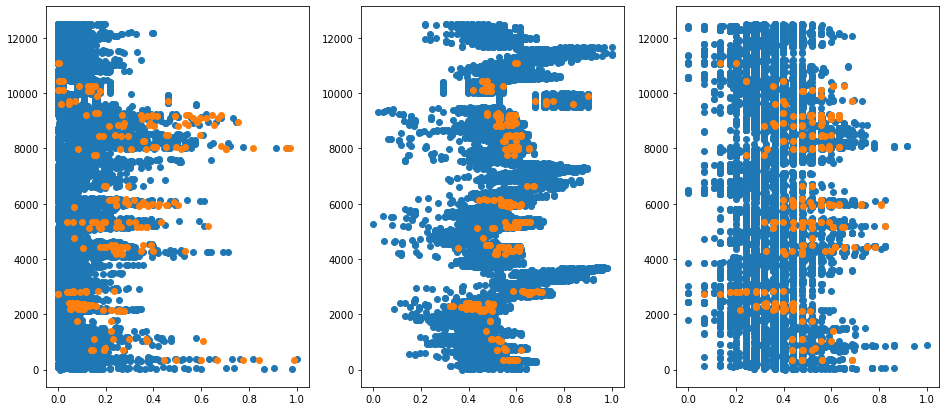

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(16, 7))
# precip
ax[0].scatter(dl0_train['precip_72hr'], dl0_labels)
ax[0].scatter(dl1_train['precip_72hr'], dl1_labels)

# temp
ax[1].scatter(dl0_train['temp_max_72hr'], dl0_labels)
ax[1].scatter(dl1_train['temp_max_72hr'], dl1_labels)

# wind
ax[2].scatter(dl0_train['wind_speed_72hr'], dl0_labels)
ax[2].scatter(dl1_train['wind_speed_72hr'], dl1_labels)

plt.show()

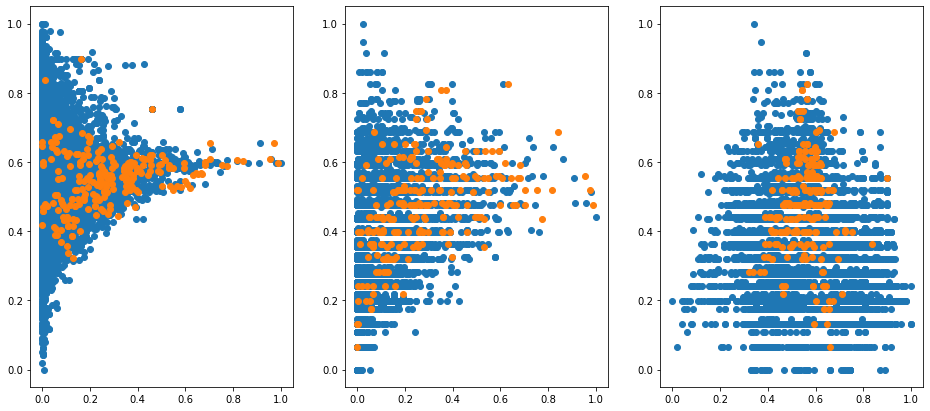

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(16, 7))
ax[0].scatter(dl0_train['precip_72hr'], dl0_train['temp_max_72hr'])
ax[0].scatter(dl1_train['precip_72hr'], dl1_train['temp_max_72hr'])

ax[1].scatter(dl0_train['precip_72hr'], dl0_train['wind_speed_72hr'])
ax[1].scatter(dl1_train['precip_72hr'], dl1_train['wind_speed_72hr'])

ax[2].scatter(dl0_train['temp_max_72hr'], dl0_train['wind_speed_72hr'])
ax[2].scatter(dl1_train['temp_max_72hr'], dl1_train['wind_speed_72hr'])
plt.show()

**Note to self:**: would there be any way to separate out wet from dry avalanches? I think the above three plots show that there is a mixture (range) of maximum temperatures, maximum windspeeds, and sum of precip values that are causing high avalanche danger to be forecasted but there should be some way of separating them. Below is how I recoded the avalanche problems in another Notebook, maybe this could help? Then try to color the above plots by wet or dry.

Here, we want to combine and drop some problems. Problem 0 means that it wasn't given, and problem 3 is new-loose which is hard to predict. We can also combine problems 2 (glide) and 7 (wet-slab) to just be 1 problem (wet-slab).

```python
# could use CLASS_danger_level or CLASS_problem_1
train_labels = labels.loc[:, ['CLASS_problem_1']]

drop_prob0_idx = train_labels.index[np.where(np.logical_or(train_labels == 0, train_labels == 3))[0]]

train_labels.drop(drop_prob0_idx, inplace=True)
train.drop(drop_prob0_idx, inplace=True)

train_labels.replace(2, 7, inplace=True)
np.unique(train_labels)

# Now we should reassign labels to go from 0 - number of unique values.
train_labels.replace(1, 0, inplace=True)
train_labels.replace(4, 1, inplace=True)
train_labels.replace(5, 2, inplace=True)
train_labels.replace(6, 3, inplace=True)
train_labels.replace(7, 4, inplace=True)
```

So now the avalanche problems are encoded like so:
- 0: drift-slab
- 1: new-slab
- 2: pwl-slab
- 3: wet-loose
- 4: glide and wet-slab

# Split data

In [36]:
train_idx = [3007, 3012, 3010, 3009, 3013, 3017, 3014, 3032, 
             3027, 3029, 3022, 3031, 3023, 3037, 3024, 3028]
val_idx =   [3011, 3016, 3035]
test_idx =  [3006, 3015, 3034]

X_train = [train.loc[idx].values for idx in train_idx]
y_train = [train_labels.loc[idx].values for idx in train_idx]

X_val = [train.loc[idx].values for idx in val_idx]
y_val = [train_labels.loc[idx].values for idx in val_idx]

X_test = [train.loc[idx].values for idx in test_idx]
y_test = [train_labels.loc[idx].values for idx in test_idx]

In [37]:
def pad_sequence(arr, length):
    """
    This method will pad a m x n array so that m is perfectly
    divisible by length. That is, m % length == 0.
    
    Arguments:
        arr(array): m x n array where there are n input features of length m
        length(int): what we want the length of of arr to be divisible by
        
    Returns:
        padded(array): new padded array
    """
    n_features = arr.shape[1]
    remainder = arr.shape[0] % length
    if remainder == 0: # then nothing to pad
        return arr
    
    pad_length = length - remainder
    to_add = np.zeros((pad_length, n_features))
    padded = np.concatenate([arr, to_add])
    #padded = np.concatenate([to_add, arr])
    
    return padded

In [38]:
sequence_length = 7 # this is an arbitrary choice, a hyperparameter
X_train_pad = [pad_sequence(arr, sequence_length) for arr in X_train]
y_train_pad = [pad_sequence(arr, sequence_length) for arr in y_train]

X_val_pad = [pad_sequence(arr, sequence_length) for arr in X_val]
y_val_pad = [pad_sequence(arr, sequence_length) for arr in y_val]

X_test_pad = [pad_sequence(arr, sequence_length) for arr in X_test]
y_test_pad = [pad_sequence(arr, sequence_length) for arr in y_test]

In [39]:
# reshape data into (samples, timesteps, features)
X_concat_train = np.concatenate(X_train)
y_concat_train = np.concatenate(y_train)

X_concat_val = np.concatenate(X_val)
y_concat_val = np.concatenate(y_val)

print(X_concat_train.shape)
print(y_concat_train.shape)

print(X_concat_val.shape)
print(y_concat_val.shape)

(8933, 57)
(8933, 1)
(1722, 57)
(1722, 1)


In order to use the recall metric, you need to have your vector of binary values one-hot encoded as a 2D matrix. We can do that below.

In [40]:
encoder = OneHotEncoder()
y_concat_train = encoder.fit_transform(y_concat_train).toarray()
y_concat_val = encoder.fit_transform(y_concat_val).toarray()

In [41]:
batchX_train, batchY_train = batch_data(X_concat_train, y_concat_train, sequence_length)
batchX_val, batchY_val = batch_data(X_concat_val, y_concat_val, sequence_length)

(8926, 7, 57) (8926, 2)
(1715, 7, 57) (1715, 2)


# Training a neural network

## DNN
We can define our neural network below. This is a multiclass classification problem, meaning that we need as many output units in the last layer as there are unique labels in our training set. It also means that we should use a softmax activation in the last layer and some form of categorical crossentropy as the loss function.

### Day-of DNN

In [124]:
# network params
input_neurons = 100
output_neurons = len(np.unique(y_concat_train))
drop = 0.3

# training params
num_epochs = 1200
alpha = 1e-4
batch_size = len(X_concat_train)
criterion = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=alpha)

In [125]:
print(batch_size)

8933


In [126]:
# reshape data into (samples, timesteps, features)
X_concat_train = np.expand_dims(X_concat_train, 0)
X_concat_val = np.expand_dims(X_concat_val, 0)

print(X_concat_train.shape)
print(y_concat_train.shape)
print(X_concat_val.shape)
print(y_concat_val.shape)

(1, 8933, 57)
(8933, 2)
(1, 1722, 57)
(1722, 2)


In [127]:
dnn_reg = create_dnn(X_concat_train, input_neurons, drop, output_neurons, True)

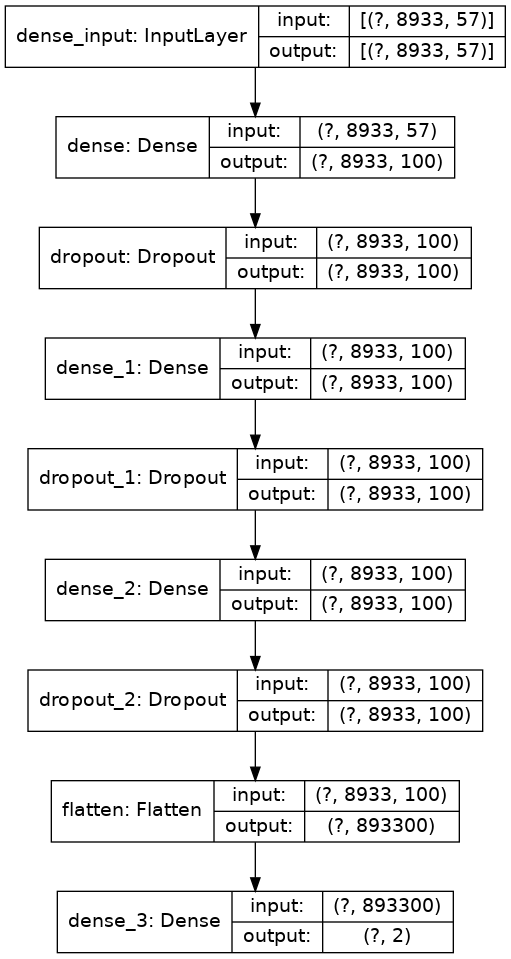

In [128]:
# being able to print model architectures in tensorflow is
# dependent on having pydot and graphviz packages installed
tf.keras.utils.plot_model(dnn_reg, 'dnn_architecture.png', show_shapes=True)

In [129]:
# dnn_reg_history = train(dnn_reg, X_concat_train, y_concat_train, 
#                         X_concat_val, y_concat_val, criterion, optimizer, 
#                         batch_size, num_epochs, weights)

In [130]:
# plot_history(dnn_reg_history)

In [131]:
# preds = plot_confusion_matrix(dnn_reg, X_concat_val, np.argmax(y_concat_val, axis=1))

**This is the same problem as before, the mismatch between batch statistics in Keras and Scikit-Learn. Since each sample has size (1, n features), we are not getting the correct precision curve.**

### Window DNN

In [42]:
# network params
input_neurons = 100
output_neurons = len(np.unique(y_concat_train))
drop = 0.3

# training params
num_epochs = 1200
alpha = 1e-4
batch_size = 8
criterion = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=alpha)

Links for self training loop, metrics:
- https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
- https://keras.io/guides/writing_a_training_loop_from_scratch/
- https://theaisummer.com/tensorflow-training-loop/

And where I have done similar things in PyTorch:
- https://github.com/Jakidxav/udacity_ml_pytorch/blob/master/pytorch_image_classifier/image_classifier_pytorch.ipynb
- https://github.com/Jakidxav/udacity_deep_learning/blob/master/rnn_tv_script_generation/rnn_tv_script_generation.ipynb
- https://github.com/Jakidxav/udacity_deep_learning/blob/master/dcgan_generate_flowers/dcgan_flower_generation.ipynb

In [150]:
print(batchX_train.shape)
print(batchY_train.shape)

(8926, 7, 57)
(8926, 2)


```python
# https://stackoverflow.com/questions/56382500/calculate-recall-for-each-class-after-each-epoch-in-tensorflow-2

# Model -- Binary classifier
binary_model = Sequential()
binary_model.add(Dense(16, input_shape=(2,), activation='relu'))
binary_model.add(Dense(8, activation='relu'))
binary_model.add(Dense(1, activation='sigmoid'))
binary_model.compile('adam', loss='binary_crossentropy')

# callback to find metrics at epoch end
class Metrics(Callback):
    def __init__(self, x, y):
        self.x = x
        self.y = y if (y.ndim == 1 or y.shape[1] == 1) else np.argmax(y, axis=1)
        self.reports = []

    def on_epoch_end(self, epoch, logs={}):
        y_hat = np.asarray(self.model.predict(self.x))
        y_hat = np.where(y_hat > 0.5, 1, 0) if (y_hat.ndim == 1 or y_hat.shape[1] == 1)  else np.argmax(y_hat, axis=1)
        report = classification_report(self.y,y_hat,output_dict=True)
        self.reports.append(report)
        return
   
    # Utility method
    def get(self, metrics, of_class):
        return [report[str(of_class)][metrics] for report in self.reports]
    
# Generate some train data (2 class) and train
x, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
metrics_binary = Metrics(x,y)
binary_model.fit(x, y, epochs=30, callbacks=[metrics_binary])

# Plotting 
fig, ax = plt.subplots(1, 2, figsize=(12, 7))

ax[0].plot(metrics_binary.get('recall', 0), label='Class 0 recall') 
ax[0].plot(metrics_binary.get('recall', 1), label='Class 1 recall') 

ax[1].plot(metrics_binary.get('precision', 0), label='Class 0 precision') 
ax[1].plot(metrics_binary.get('precision', 1), label='Class 1 precision') 

plt.legend()
plt.show()

plt.close('all')
for m in ['recall', 'precision']:
    for c in [0,1]:
        plt.plot(metrics_multiclass.get(m,c), label='Class {0} {1}'.format(c,m))
        
plt.legend(loc='lower right')
plt.show()
```

In [173]:
window_dnn_reg = create_dnn(batchX_train, input_neurons, drop, output_neurons, True)

window_dnn_reg_history = train(window_dnn_reg, batchX_train, batchY_train, 
                               batchX_val, batchY_val, criterion, optimizer, 
                               batch_size, num_epochs, weights)

Epoch 000: Loss: 0.514, Accuracy: 98.230%


KeyboardInterrupt: 

**THIS IS WHAT I WANT:**
- **https://stackoverflow.com/questions/56382500/calculate-recall-for-each-class-after-each-epoch-in-tensorflow-2**

The above error is occuring because the batch size is way to big. So I need to figure out how to train on smaller batches and then take the whole batch loss.

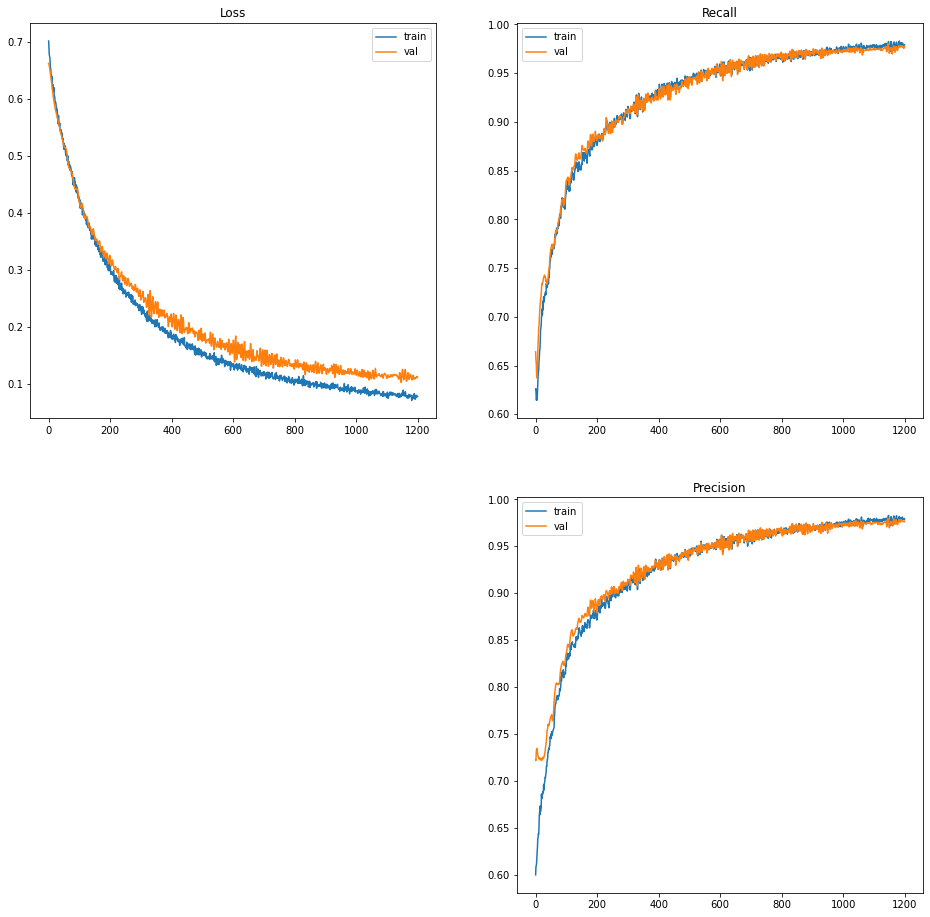

In [53]:
plot_history(window_dnn_reg_history)

**I could also look into this metric: https://www.tensorflow.org/api_docs/python/tf/keras/metrics/PrecisionAtRecall**

precision: [0.99458158 0.44444444]
recall:    [0.98216409 0.72727273]
fscore:    [0.98833383 0.55172414]


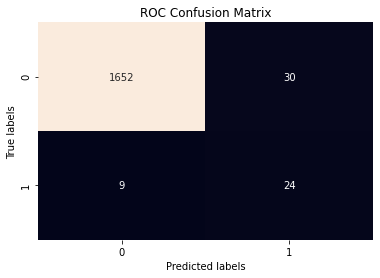

In [54]:
preds = plot_confusion_matrix(window_dnn_reg, batchX_val, np.argmax(batchY_val, axis=1))

This is looking fairly good, but, ideally that bottom left square would be 0 (no false negatives). We can play with the sensitivity to try and get that square to 0, and then use the same threshold value for the test set. I am interested in doing this because I believe there are many instances where the danger level is 4, but the model is not able to distinguish it from a danger level of 3.

In plain text, this strategy would be something like:
> "We care most about predicting a danger level 4 when it is a danger level 4, and less about over-predicting danger level 4's."

So ideally, we would have a precision greater than 50% and a recall score as close to 100% as possible. **It might be worth looking at why the Keras recall score says 95+% on the validation set while the scikit-learn version gets only 78%.** I believe that I need to do a custom training loop because Keras/TF is evaluating the metrics per batch and not across the entire dataset. So I would essentially have to train on a batch of data, predict on the training data and validation data to get an "overall" score using Scikit-Learn's `score()` method, append that to a list of values. I think Keras may be giving me an average of recall/precision across batches which is not what I want.

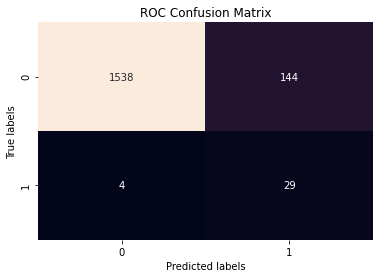

In [55]:
probs = window_dnn_reg.predict(batchX_val)
to_save = []
for proba_pair in probs:
    if(proba_pair[1] > 0.05):
        to_save.append(1)
    else: 
        to_save.append(0)

#use seaborn's sns.heatmap() function for pretty plotting of confusion matrix
cm = confusion_matrix(np.argmax(batchY_val, axis=1), to_save)
ax = sns.heatmap(cm, annot=True, fmt='d', cbar=False)

#set x and y labels, as well as title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('ROC Confusion Matrix')

plt.show()

When we do this, we can limit the number of false negatives, but at the cost of predicting danger level 4 *much* more often. This makes me a little uncomfortable, because I don't want to over-optimize for the validation set and have it not generalize to the test set.

Maybe we should use some sort of early stopping?
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
- https://stackoverflow.com/questions/59438904/applying-callbacks-in-a-custom-training-loop-in-tensorflow-2-0

Or perhaps we could save the model each time we improve on recall?

In [56]:
# recall
greater_than = np.where(np.array(window_dnn_reg_history.history['val_recall']) > 0.99)[0]
for val in greater_than:
    print('Recall:', window_dnn_reg_history.history['val_recall'][val])
    
# loss
less_than = np.where(np.array(window_dnn_reg_history.history['val_loss']) < 0.05)[0] #it never reaches that low
for val in less_than:
    print('Loss:', window_dnn_reg_history.history['val_loss'][val])

# Summary so far:
- batching data works better than non-batching, although after trying several values for the window size, most perform the same
- regularization definitely helps
- DNNs perform the best overall, RNNs perform okay when only using the RegObs data
- using both regobs and varsom data improves performance
- class weights work well
- classifying danger level 4 as an outlier works better than trying to classify danger levels 1-4
- I am no longer optimizing for accuracy, only loss and recall
- I am not sure of the effect of shuffling when using DNNs. Performance seems comparable.
- 2 vs 3 layer DNNs perform similarly, although I received my best results so far with a 2 layer DNN. This might be worth looking at in hyperopt.

I believe that I am reaching unreducible error in the validation set. I believe that there are some danger level 4's that look like 3's, and have never reached lower than 3 false negatives after training (and before playing with the prediction sensitivity). I think I have found a batch size, learning rate, epoch number, regularization parameter, and several other optimal hyperparameters, so it may be time to predict on the test set after running a bunch of models and saving the best one. I need to find a way to do this with the recall metric.